In [2]:
import os
from pathlib import Path
import torch
import re
import random
!pip install datasets
import transformers, datasets
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer
import tqdm
from torch.utils.data import Dataset, DataLoader
import itertools
import math
import torch.nn.functional as F
import numpy as np
from torch.optim import Adam

# Data Preparation

In [ ]:
import random
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import BertTokenizer
import nltk

# Download sentence tokenizer
nltk.download("punkt")
nltk.download("punkt_tab")


class BERTWikiTextDataset(Dataset):
    def __init__(self, tokenizer, split="train", seq_len=128):
        """
        Prepares WikiText-2 dataset for BERT pretraining.
        Includes Masked Language Modeling (MLM) and Next Sentence Prediction (NSP).
        """
        self.tokenizer = tokenizer
        self.seq_len = seq_len

        # Load specified split of the dataset
        #dataset = load_dataset("wikitext", "wikitext-2-raw-v1")[split]
        dataset = load_dataset("wikitext", "wikitext-103-raw-v1")[split]

        # Extract raw text and split into sentences
        self.sentences = []
        for entry in dataset["text"]:
            self.sentences.extend(nltk.sent_tokenize(entry.strip()))

        # Remove empty sentences
        self.sentences = [s for s in self.sentences if s.strip()]
        self.corpus_lines = len(self.sentences) - 1  # Last sentence can't form a pair

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, index):
        """Returns a dictionary with tokenized inputs for BERT pretraining."""
        # Get sentence pair (t1, t2) for NSP
        t1, t2, is_next_label = self.get_sent(index)

        # Tokenize with BERT tokenizer (convert to token IDs)
        t1_tokens = self.tokenizer.tokenize(t1)
        t2_tokens = self.tokenizer.tokenize(t2)

        # Apply BERT-style word masking (MLM)
        t1_random, t1_label = self.random_word(t1_tokens)
        t2_random, t2_label = self.random_word(t2_tokens)

        # Add CLS and SEP tokens
        t1 = ["[CLS]"] + t1_random + ["[SEP]"]
        t2 = t2_random + ["[SEP]"]
        t1_label = ["[PAD]"] + t1_label + ["[PAD]"]
        t2_label = t2_label + ["[PAD]"]

        # Convert tokens to IDs
        t1_ids = self.tokenizer.convert_tokens_to_ids(t1)
        t2_ids = self.tokenizer.convert_tokens_to_ids(t2)
        t1_label_ids = self.tokenizer.convert_tokens_to_ids(t1_label)
        t2_label_ids = self.tokenizer.convert_tokens_to_ids(t2_label)

        # Combine into single sequence
        segment_label = ([1] * len(t1_ids) + [2] * len(t2_ids))[:self.seq_len]
        bert_input = (t1_ids + t2_ids)[:self.seq_len]
        bert_label = (t1_label_ids + t2_label_ids)[:self.seq_len]

        # Padding to seq_len
        pad_id = self.tokenizer.pad_token_id
        padding = [pad_id] * (self.seq_len - len(bert_input))

        bert_input.extend(padding)
        bert_label.extend(padding)
        segment_label.extend(padding)

        output = {
            "bert_input": torch.tensor(bert_input),
            "bert_label": torch.tensor(bert_label),
            "segment_label": torch.tensor(segment_label),
            "is_next": torch.tensor(is_next_label),
        }

        return output

    def random_word(self, tokens):
        """Applies BERT-style word masking for Masked Language Modeling (MLM)."""
        output_label = []
        output = []

        for token in tokens:
            prob = random.random()

            # 15% chance of being masked
            if prob < 0.15:
                prob /= 0.15

                if prob < 0.8:
                    output.append("[MASK]")  # 80% mask token
                elif prob < 0.9:
                    output.append(random.choice(list(self.tokenizer.vocab.keys())))  # 10% random word
                else:
                    output.append(token)  # 10% keep original

                output_label.append(token)
            else:
                output.append(token)
                output_label.append("[PAD]")  # No prediction needed

        return output, output_label

    def get_sent(self, index):
        """Returns a consecutive sentence pair or a randomly chosen negative pair."""
        t1 = self.sentences[index]

        if random.random() > 0.5 and index + 1 < len(self.sentences):
            return t1, self.sentences[index + 1], 1  # Positive pair
        else:
            return t1, self.get_random_sentence(), 0  # Negative pair

    def get_random_sentence(self):
        """Returns a random sentence from WikiText dataset."""
        return random.choice(self.sentences)


# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create datasets for training, validation, and test
train_dataset = BERTWikiTextDataset(tokenizer=tokenizer, split="train", seq_len=128)
val_dataset = BERTWikiTextDataset(tokenizer=tokenizer, split="validation", seq_len=128)
test_dataset = BERTWikiTextDataset(tokenizer=tokenizer, split="test", seq_len=128)




In [6]:
import torch
from torch.utils.data import DataLoader

# Set sequence length to 64
SEQ_LEN = 128

# Initialize tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#dataset = BERTWikiTextDataset(tokenizer=tokenizer, seq_len=SEQ_LEN)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader=DataLoader(test_dataset,  batch_size=32, shuffle=True, pin_memory=True)

# Get one batch
sample_data = next(iter(train_loader))

print("Batch Size:", sample_data["bert_input"].size())  # Should print (32, 64)


Batch Size: torch.Size([32, 128])


# Modeling

In [8]:
import math
import torch

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))  # Fixed
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))  # Fixed

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        return self.pe[:, :seq_len]

class BERTEmbedding(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len=128, dropout=0.1):
        super().__init__()
        self.token = torch.nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.segment = torch.nn.Embedding(3, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, sequence, segment_label):
        token_embed = self.token(sequence)
        pos_embed = self.position(sequence)
        segment_embed = self.segment(segment_label)
        x = token_embed + pos_embed + segment_embed
        return self.dropout(x)
# Move model and data to the same device
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_layer = BERTEmbedding(vocab_size=10000, embed_size=768, seq_len=128).to(device)

# Example input (ensure data is on the same device)
sample_data = {
    'bert_input': torch.randint(0, 10000, (32, 128)).to(device),  # [batch_size, seq_len]
    'segment_label': torch.randint(0, 2, (32, 128)).to(device)
}

embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])
print(embed_result.size())  # Output: torch.Size([32, 128, 768])

torch.Size([32, 128, 768])


In [9]:
### attention layers
class MultiHeadedAttention(torch.nn.Module):

    def __init__(self, heads, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = torch.nn.Dropout(dropout)

        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)
        self.output_linear = torch.nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model)
        mask of shape: (batch_size, 1, 1, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)

        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))

        # fill 0 mask with super small number so it wont affect the softmax weight
        # (batch_size, h, max_len, max_len)
        scores = scores.masked_fill(mask == 0, -1e9)

        # (batch_size, h, max_len, max_len)
        # softmax to put attention weight for all non-pad tokens
        # max_len X max_len matrix of attention
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, d_model)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        # (batch_size, max_len, d_model)
        return self.output_linear(context)

class FeedForward(torch.nn.Module):
    "Implements FFN equation"

    def __init__(self, d_model, middle_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.fc1 = torch.nn.Linear(d_model, middle_dim)
        self.fc2 = torch.nn.Linear(middle_dim, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

class EncoderLayer(torch.nn.Module):
    def __init__(
        self,
        d_model=768,
        heads=12,
        feed_forward_hidden=768 * 4,
        dropout=0.1
        ):
        super(EncoderLayer, self).__init__()
        self.layernorm = torch.nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        # embeddings: (batch_size, max_len, d_model)
        # encoder mask: (batch_size, 1, 1, max_len)
        # result: (batch_size, max_len, d_model)
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        # residual layer
        interacted = self.layernorm(interacted + embeddings)
        # bottleneck
        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move model and data to the device
embed_layer = BERTEmbedding(vocab_size=len(tokenizer.vocab), embed_size=768, seq_len=128).to(device)
sample_data = {k: v.to(device) for k, v in sample_data.items()}

# Forward pass through embedding layer
embed_result = embed_layer(sample_data['bert_input'], sample_data['segment_label'])

# Create mask (already on the correct device)
mask = (sample_data['bert_input'] > 0).unsqueeze(1).unsqueeze(1)  # [batch_size, 1, 1, seq_len]

# Move transformer block to the device and run
transformer_block = EncoderLayer().to(device)
transformer_result = transformer_block(embed_result, mask)
print(transformer_result.size())  # Should output [batch_size, seq_len, d_model]

torch.Size([32, 128, 768])


In [10]:
class BERT(torch.nn.Module):
    def __init__(self, vocab_size, d_model=512, n_layers=6, heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads
        self.feed_forward_hidden = d_model * 4

        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=d_model)
        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderLayer(d_model, heads, d_model * 4, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # Fix mask shape: [batch_size, 1, 1, seq_len]
        mask = (x > 0).unsqueeze(1).unsqueeze(1)  # Removed redundant repeat()

        x = self.embedding(x, segment_info)
        for encoder in self.encoder_blocks:
            x = encoder(x, mask)
        return x
class NextSentencePrediction(torch.nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, 2)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        # use only the first token which is the [CLS]
        return self.softmax(self.linear(x[:, 0]))

class MaskedLanguageModel(torch.nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class BERTLM(torch.nn.Module):
    def __init__(self, bert: BERT, vocab_size):
        super().__init__()
        self.bert = bert
        # These submodules will automatically use same device as bert
        self.next_sentence = NextSentencePrediction(self.bert.d_model)
        self.mask_lm = MaskedLanguageModel(self.bert.d_model, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)

### Testing with Device Management
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Move sample data to device
sample_data = {
    'bert_input': torch.randint(0, len(tokenizer.vocab), (32, 128)).to(device),
    'segment_label': torch.randint(0, 2, (32, 128)).to(device)
}

# 2. Create models and move to device
bert_model = BERT(len(tokenizer.vocab)).to(device)
bert_lm = BERTLM(bert_model, len(tokenizer.vocab)).to(device)

# 3. Forward pass
with torch.no_grad():
    bert_result = bert_model(sample_data['bert_input'], sample_data['segment_label'])
    final_result = bert_lm(sample_data['bert_input'], sample_data['segment_label'])

print("BERT Output Size:", bert_result.size())  # Should be [32, 128, 512]
print("NSP Size:", final_result[0].size())      # Should be [32, 2]
print("MLM Size:", final_result[1].size())      # Should be [32, 128, vocab_size]



BERT Output Size: torch.Size([32, 128, 512])
NSP Size: torch.Size([32, 2])
MLM Size: torch.Size([32, 128, 30522])


# Training

In [25]:
### optimizer
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [26]:
import wandb
### trainer
class BERTTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader=None,
        lr= 1e-4,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        warmup_steps=10000,
        log_freq=100,
        device='cuda'
        ):

        self.device = device
        self.model = model.to(device)
        self.train_data = train_dataloader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(
            self.optim, self.model.bert.d_model, n_warmup_steps=warmup_steps
            )

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        return self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):

        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        mode = "train" if train else "test"

        # progress bar
        data_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc="EP_%s:%d" % (mode, epoch),
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )

        for i, data in data_iter:

            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            # transpose to (m, vocab_size, seq_len) vs (m, seq_len)
            # criterion(mask_lm_output.view(-1, mask_lm_output.size(-1)), data["bert_label"].view(-1))
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            avg_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
        print(
            f"EP{epoch}, {mode}: \
            avg_loss={avg_loss / len(data_iter)}, \
            total_acc={total_correct * 100.0 / total_element}"
        )


        return avg_loss/len(data_iter)



### Updated Test Section with Validation
# Create training and validation datasets
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Training dataset
'''train_dataset = BERTWikiTextDataset(tokenizer=tokenizer, seq_len=128, split="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

# Validation dataset
val_dataset = BERTWikiTextDataset(tokenizer=tokenizer, seq_len=128, split="validation")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)'''

# Initialize model and trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_model = BERT(len(tokenizer.vocab)).to(device)
bert_lm = BERTLM(bert_model, len(tokenizer.vocab)).to(device)

bert_trainer = BERTTrainer(
    model=bert_lm,
    train_dataloader=train_loader,
    test_dataloader=val_loader,  # Add validation loader
    device=device
)


Total Parameters: 50195772


In [ ]:
wandb.init(
    project='bert_pretraining',
    name='final_try',
    config={"dataset": "wiki-103"}
)

In [ ]:
epochs = 5
best_val_loss = float('inf')  # Track the best validation loss

# Initialize WandB
for epoch in range(epochs):
    train_loss = bert_trainer.train(epoch)  # Train model
    val_loss = bert_trainer.test(epoch)  # Get validation loss

    # Log training & validation loss in WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

    # Save model only if the validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(bert_lm.state_dict(), "/kaggle/working/bert_model_wiki103.pth")
        print(f" Model saved at epoch {epoch} with improved validation loss: {val_loss:.4f}")
    else:
        print(f" No improvement in validation loss ({val_loss:.4f}), model not saved.")

#  Finish WandB logging
wandb.finish()


In [9]:
import torch
from torch.utils.data import DataLoader

# Set sequence length to 64
SEQ_LEN = 128

# Initialize tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#dataset = BERTWikiTextDataset(tokenizer=tokenizer, seq_len=SEQ_LEN)

# Create DataLoader
ft_train_loader = DataLoader(ft_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
ft_val_loader=DataLoader(ft_val_dataset, batch_size=32, shuffle=True, pin_memory=True)

# Get one batch
sample_data = next(iter(ft_train_loader))

print("Batch Size:", sample_data["bert_input"].size())  # Should print (32, 64)


Batch Size: torch.Size([32, 128])


# Fine Tuning 

In [ ]:
import torch
from datasets import load_dataset
from transformers import BertTokenizer

class AGNewsDataset:
    def __init__(self, tokenizer, split="train", seq_len=128):
        """
        Prepares AG News dataset for classification.
        """
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.dataset = load_dataset("ag_news", split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = self.dataset[index]
        return self.process_text(example["text"], example["label"])

    def process_text(self, text, label=None):
        """
        Tokenizes text and returns a dictionary suitable for BERT.
        If label is None, it's for inference.
        """
        tokens = self.tokenizer(
            text,
            truncation=True,
            max_length=self.seq_len,
            padding="max_length",
            return_tensors="pt",
        )

        output = {
            "bert_input": tokens["input_ids"].squeeze(),
            "attention_mask": tokens["attention_mask"].squeeze(),
            "segment_label": torch.zeros(self.seq_len).long(),
        }
        
        if label is not None:
            output["label"] = torch.tensor(label)  # Classification label
        
        return output

    def from_text(self, text):
        """
        Allows passing any custom news article for classification.
        """
        return self.process_text(text)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create dataset
dataset = AGNewsDataset(tokenizer, split="test", seq_len=128)

# Test on a random news article
random_text = "Apple announces new iPhone model with improved battery life."
processed_text = dataset.from_text(random_text)


In [ ]:
ft_test_dataset=AGNewsDataset(tokenizer, split="test", seq_len=128) 
ft_train_dataset=AGNewsDataset(tokenizer, split="train", seq_len=128) 
ft_val_dataset=AGNewsDataset(tokenizer, split="val", seq_len=128) 
ft_train_loader = DataLoader(ft_train_dataset, batch_size=32, shuffle=True, pin_memory=True)
ft_val_loader=DataLoader(ft_val_dataset, batch_size=32, shuffle=True, pin_memory=True)
ft_test_loader=DataLoader(ft_test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [32]:
class BERTForClassification(torch.nn.Module):
    def __init__(self, bert, num_classes):
        super().__init__()
        self.bert = bert
        self.classifier = torch.nn.Linear(bert.d_model, num_classes)
        
    def forward(self, x, segment_label):
        # Get BERT embeddings
        x = self.bert(x, segment_label)
        
        # Use [CLS] token for classification
        cls_output = x[:, 0]  # First token is [CLS]
        
        return self.classifier(cls_output)

In [33]:
pretrained_bert_lm = BERTLM(bert_model, len(tokenizer.vocab)).to(device)

pretrained_bert_lm.load_state_dict(torch.load(
    "/kaggle/input/bert-weight-wiki103/bert_model_wiki103.pth",
    map_location=device,
    weights_only=True
))


<All keys matched successfully>

In [34]:
# Extract only BERT encoder weights
bert_state_dict = {
    key.replace("bert.", ""): value 
    for key, value in pretrained_bert_lm.state_dict().items() 
    if key.startswith("bert.")
}

In [35]:
# Initialize BERT encoder
bert_encoder = BERT(vocab_size=len(tokenizer.vocab)).to(device)

# Load only encoder weights
bert_encoder.load_state_dict(bert_state_dict)

# Initialize classifier
classification_model = BERTForClassification(bert_encoder, num_classes=4).to(device)

In [36]:
optimizer = torch.optim.AdamW(classification_model.parameters(), lr=2e-5)

In [27]:
class FinetuneTrainer(BERTTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Change loss function for classification
        self.criterion = torch.nn.CrossEntropyLoss()
        
    def iteration(self, epoch, data_loader, train=True):
        avg_loss = 0.0
        total_correct = 0
        total_samples = 0

        mode = "train" if train else "val"
        data_iter = tqdm.tqdm(enumerate(data_loader),
                            desc=f"EP_{mode}:{epoch}",
                            total=len(data_loader),
                            bar_format="{l_bar}{r_bar}")

        for i, batch in data_iter:
            # Get batch data
            inputs = batch["bert_input"].to(self.device)
            segments = batch["segment_label"].to(self.device)
            labels = batch["label"].to(self.device)
            
            # Forward pass
            logits = self.model(inputs, segments)
            loss = self.criterion(logits, labels)

            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # Calculate metrics
            preds = logits.argmax(dim=-1)
            correct = (preds == labels).sum().item()
            
            avg_loss += loss.item()
            total_correct += correct
            total_samples += labels.size(0)

            # Log to wandb
            if i % self.log_freq == 0:
                wandb.log({
                    f"{mode}/loss": loss.item(),
                    f"{mode}/acc": correct/labels.size(0),
                    "epoch": epoch
                })
                data_iter.write(f"Loss: {loss.item():.4f} | Acc: {correct/labels.size(0):.2%}")

        epoch_loss = avg_loss / len(data_loader)
        epoch_acc = total_correct / total_samples
        
        print(f"Epoch {epoch} {mode.upper()} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2%}")
        wandb.log({f"{mode}/epoch_loss": epoch_loss, 
                 f"{mode}/epoch_acc": epoch_acc})
        
        return epoch_loss

In [40]:
from sklearn.metrics import f1_score
import numpy as np

class FinetuneTrainer(BERTTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.best_val_f1 = -np.inf  # Track best validation F1
        
    def iteration(self, epoch, data_loader, train=True):
        avg_loss = 0.0
        total_correct = 0
        total_samples = 0
        all_preds = []
        all_labels = []

        mode = "train" if train else "val"
        data_iter = tqdm.tqdm(enumerate(data_loader),
                            desc=f"EP_{mode}:{epoch}",
                            total=len(data_loader),
                            bar_format="{l_bar}{r_bar}")

        for i, batch in data_iter:
            inputs = batch["bert_input"].to(self.device)
            segments = batch["segment_label"].to(self.device)
            labels = batch["label"].to(self.device)

            # Forward pass
            logits = self.model(inputs, segments)
            loss = self.criterion(logits, labels)

            if train:
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()

            # Calculate metrics
            preds = logits.argmax(dim=-1)
            correct = (preds == labels).sum().item()
            
            # Store for F1 calculation
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

            avg_loss += loss.item()
            total_correct += correct
            total_samples += labels.size(0)

            # Batch logging
            if i % self.log_freq == 0:
                batch_acc = correct / labels.size(0)
                wandb.log({
                    f"{mode}/batch_loss": loss.item(),
                    f"{mode}/batch_acc": batch_acc,
                    "epoch": epoch
                })

        # Calculate epoch metrics
        epoch_loss = avg_loss / len(data_loader)
        epoch_acc = total_correct / total_samples
        epoch_f1 = f1_score(
            np.concatenate(all_labels),
            np.concatenate(all_preds),
            average="macro"
        )

        # Epoch logging
        print(f"Epoch {epoch} {mode.upper()} | Loss: {epoch_loss:.4f} | "
              f"Acc: {epoch_acc:.2%} | F1: {epoch_f1:.4f}")
        wandb.log({
            f"{mode}/epoch_loss": epoch_loss,
            f"{mode}/epoch_acc": epoch_acc,
            f"{mode}/epoch_f1": epoch_f1,
            "epoch": epoch
        })

        return epoch_loss, epoch_acc, epoch_f1

    def run(self, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            # Training
            train_loss, train_acc, train_f1 = self.iteration(
                epoch, train_loader, train=True
            )
            
            # Validation
            with torch.no_grad():
                val_loss, val_acc, val_f1 = self.iteration(
                    epoch, val_loader, train=False
                )

            # Save best model (validation F1 based)
            if val_f1 > self.best_val_f1:
                print(f"Validation F1 improved {self.best_val_f1:.4f} → {val_f1:.4f}")
                torch.save(self.model.state_dict(), "/kaggle/working/best_ft_model.pth")
                self.best_val_f1 = val_f1

            # Combined epoch report
            wandb.log({
                "epoch": epoch,
                "train/loss": train_loss,
                "train/acc": train_acc,
                "train/f1": train_f1,
                "val/loss": val_loss,
                "val/acc": val_acc,
                "val/f1": val_f1
            })

In [41]:
# Initialize with same parameters as BERTTrainer
trainer = FinetuneTrainer(classification_model, device, optimizer, log_freq=10)

# Run training with early stopping potential
trainer.run(ft_train_loader, ft_val_loader, epochs=5)

Total Parameters: 34539012


EP_train:0: 100%|| 3375/3375 [08:29<00:00,  6.62it/s]


Epoch 0 TRAIN | Loss: 0.9341 | Acc: 57.20% | F1: 0.5699


EP_val:0: 100%|| 375/375 [00:32<00:00, 11.65it/s]


Epoch 0 VAL | Loss: 0.5579 | Acc: 81.04% | F1: 0.8018
Validation F1 improved -inf → 0.8018


EP_train:1: 100%|| 3375/3375 [08:23<00:00,  6.71it/s]


Epoch 1 TRAIN | Loss: 0.3993 | Acc: 86.21% | F1: 0.8620


EP_val:1: 100%|| 375/375 [00:29<00:00, 12.70it/s]


Epoch 1 VAL | Loss: 0.4489 | Acc: 84.53% | F1: 0.8446
Validation F1 improved 0.8018 → 0.8446


EP_train:2: 100%|| 3375/3375 [08:04<00:00,  6.97it/s]


Epoch 2 TRAIN | Loss: 0.5563 | Acc: 77.95% | F1: 0.7791


EP_val:2: 100%|| 375/375 [00:28<00:00, 12.97it/s]


Epoch 2 VAL | Loss: 0.3596 | Acc: 87.90% | F1: 0.8787
Validation F1 improved 0.8446 → 0.8787


EP_train:3: 100%|| 3375/3375 [08:03<00:00,  6.98it/s]


Epoch 3 TRAIN | Loss: 0.3785 | Acc: 87.37% | F1: 0.8735


EP_val:3: 100%|| 375/375 [00:29<00:00, 12.89it/s]


Epoch 3 VAL | Loss: 0.3775 | Acc: 87.47% | F1: 0.8729


EP_train:4: 100%|| 3375/3375 [08:02<00:00,  6.99it/s]


Epoch 4 TRAIN | Loss: 0.3582 | Acc: 87.86% | F1: 0.8784


EP_val:4: 100%|| 375/375 [00:28<00:00, 13.11it/s]


Epoch 4 VAL | Loss: 0.3523 | Acc: 88.10% | F1: 0.8812
Validation F1 improved 0.8787 → 0.8812


In [44]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Ensure model is in evaluation mode
classification_model.eval()

all_preds, all_labels = [], []

with torch.no_grad():  # No gradient computation needed
    for batch in ft_test_loader:
        x = batch['bert_input'].to(device)
        segment_label = batch['segment_label'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = classification_model(x, segment_label)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute and print classification metrics
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88      1900
           1       0.95      0.95      0.95      1900
           2       0.81      0.89      0.85      1900
           3       0.84      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Confusion Matrix:
 [[1570   64  143  123]
 [  23 1805   53   19]
 [  32   13 1689  166]
 [  34   10  189 1667]]


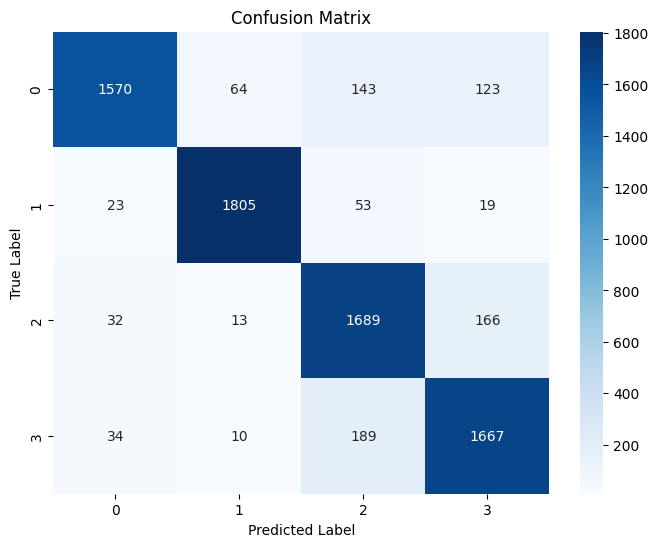

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define category labels


# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [64]:
import torch

# Define AG News category labels
labels = ["World", "Sports", "Business", "Sci/Tech"]

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
classification_model.to(device)
classification_model.eval()

# Example: Random news article
random_texts = ["RCB defeated LSG in yesterdays IPL match", "Apple announced release of a new iphone", "Trump lost the elections"]

for random_text in random_texts: 
    processed_text = dataset.from_text(random_text)
    input_data = {k: v.unsqueeze(0).to(device) for k, v in processed_text.items()} 
    with torch.no_grad():
        logits = classification_model(input_data["bert_input"], input_data["segment_label"])  # Forward pass
        predicted_class = torch.argmax(logits, dim=1).item()  
        print(f"News: {random_text}\nPredicted Category: {labels[predicted_class]}")



News: RCB defeated LSG in yesterdays IPL match
Predicted Category: Sports
News: Apple announced release of a new iphone
Predicted Category: Business
News: Trump lost the elections
Predicted Category: World
